In [37]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

path2project = "/Users/don_giraffe/Desktop/TPF/OneDrive_1_2025-6-11"
year_month = '2024-01'

plcs_with_on_off = pd.read_csv(os.path.join(path2project, 'data', 'plcs_with_on_off_jan.csv'), index_col=0)
stops_metadata = pd.read_csv(os.path.join(path2project, 'data', 'stops_metadata_jan.csv'), index_col=0)

In [38]:
print(plcs_with_on_off)
print(stops_metadata)

                Day              Arrival            Departure  \
Vehicle                                                         
168      2024-01-25  2024-01-25 11:11:51  2024-01-25 11:11:57   
168      2024-01-25  2024-01-25 11:13:45  2024-01-25 11:13:45   
168      2024-01-25  2024-01-25 11:14:23  2024-01-25 11:14:23   
168      2024-01-25  2024-01-25 11:14:56  2024-01-25 11:14:56   
168      2024-01-25  2024-01-25 11:15:21  2024-01-25 11:15:21   
...             ...                  ...                  ...   
855      2024-01-15  2024-01-15 23:18:41  2024-01-15 23:19:04   
855      2024-01-15  2024-01-15 23:19:52  2024-01-15 23:19:52   
855      2024-01-15  2024-01-15 23:20:18  2024-01-15 23:20:26   
855      2024-01-15  2024-01-15 23:21:28  2024-01-15 23:21:37   
855      2024-01-15  2024-01-15 23:22:39  2024-01-15 23:22:39   

             Punctuality  Distance   Latitude  Longitude  Data  Timetable  \
Vehicle                                                                     


### Waiting time

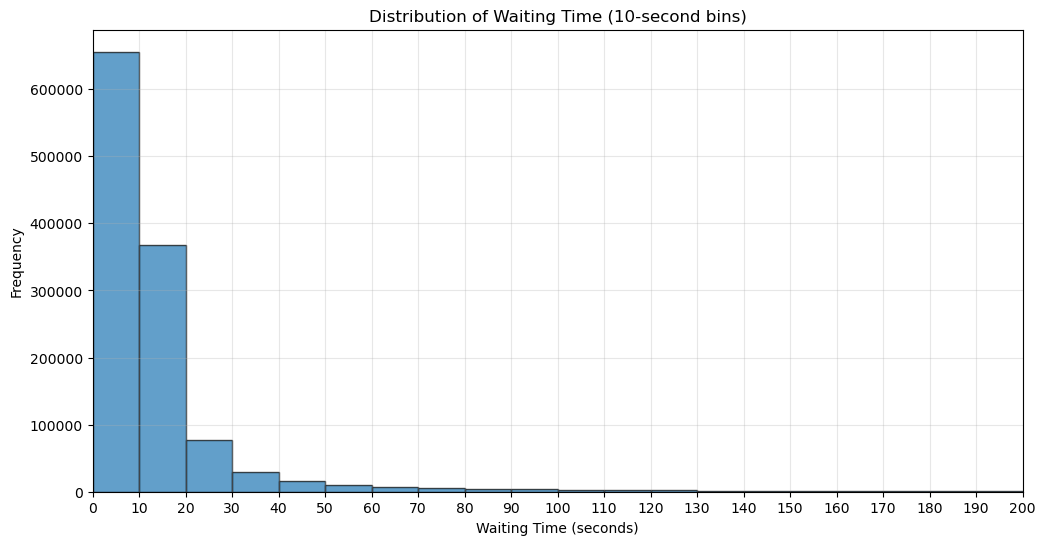

Rows with waiting time > 120 seconds: 45139
Total rows: 1226569
Percentage: 3.68%


In [ ]:

# Plot distribution (limit x-axis to 200 seconds with 10-second bins)
plt.figure(figsize=(12, 6))
bins = range(0, 201, 10)  # Create bins every 10 seconds from 0 to 200
plt.hist(plcs_with_on_off['Waiting_Time_Seconds'], bins=bins, alpha=0.7, edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Time (10-second bins)')
plt.xlim(0, 200)
plt.xticks(range(0, 201, 10))
plt.grid(True, alpha=0.3)
plt.show()

# Count rows with waiting time > 120 seconds
count_over_120 = (plcs_with_on_off['Waiting_Time_Seconds'] > 120).sum()
total_rows = len(plcs_with_on_off)

print(f"Rows with waiting time > 120 seconds: {count_over_120}")
print(f"Total rows: {total_rows}")
print(f"Percentage: {count_over_120/total_rows*100:.2f}%")

In [4]:
# Top 10 stops by passenger boarding activity (On_Second_Class only)
stops = plcs_with_on_off.groupby('StopName')['On_Second_Class'].sum()
top_10_stops = stops.nlargest(10).index.tolist()

# Top 10 lines by passenger boarding activity (On_Second_Class only)
lines = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines.nlargest(10).index.tolist()

print("Top 10 Stops (by boarding passengers):")
print(top_10_stops)

print("\nTop 10 Lines (by boarding passengers):")
print(top_10_lines)

Top 10 Stops (by boarding passengers):
['Fribourg/Freiburg, Pl. Gare', 'Fribourg, St-Pierre', 'Fribourg/Freiburg, gare routière', 'Fribourg, Charmettes', 'Fribourg, Tilleul/Cathédrale', 'Fribourg, Industrie', 'Marly, Grand Pré', "Bulle, Château-d'en-Bas", 'Fribourg, Boschung', 'Bulle, Place de la Gare']

Top 10 Lines (by boarding passengers):
[1.0, 2.0, 5.0, 6.0, 8.0, 3.0, 7.0, 202.0, 201.0, 4.0]


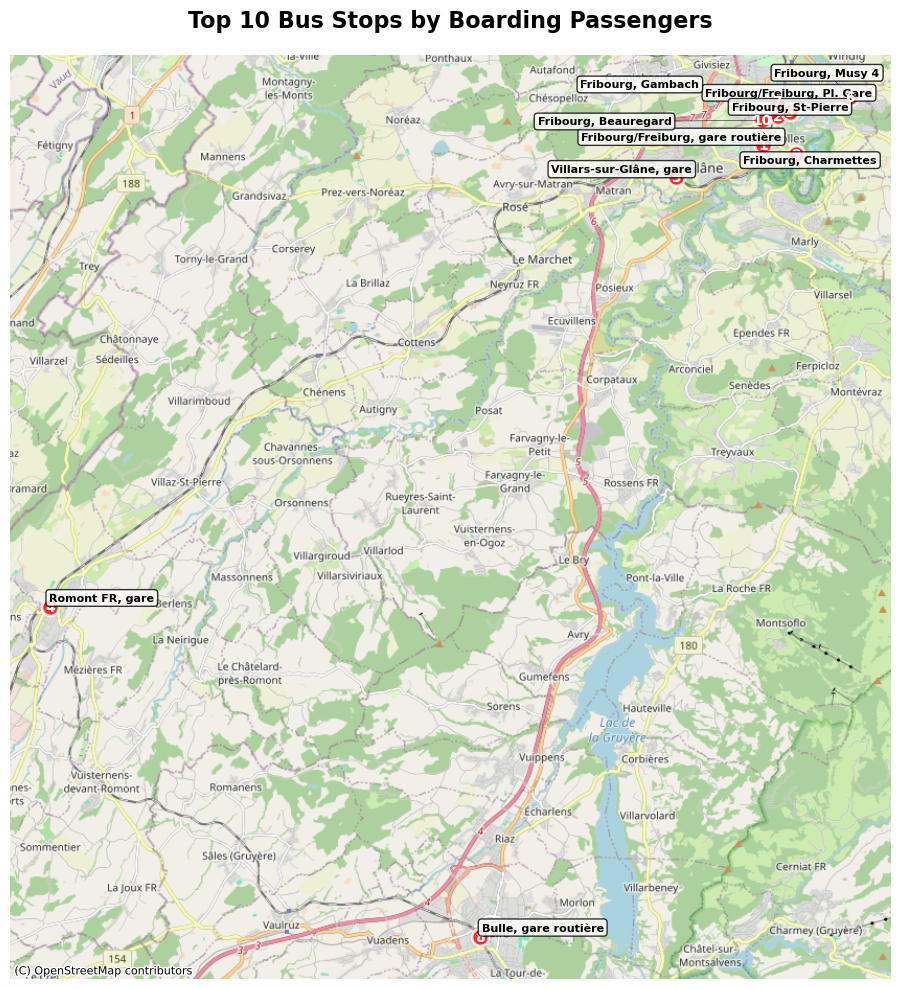

Top 10 stops by boarding passengers:
1. Fribourg/Freiburg, gare routière - 66531 boarding passengers
2. Fribourg/Freiburg, Pl. Gare - 5385 boarding passengers
3. Villars-sur-Glâne, gare - 1556 boarding passengers
4. Romont FR, gare - 1517 boarding passengers
5. Fribourg, St-Pierre - 1484 boarding passengers
6. Fribourg, Musy 4 - 1269 boarding passengers
7. Fribourg, Gambach - 1214 boarding passengers
8. Bulle, gare routière - 1197 boarding passengers
9. Fribourg, Charmettes - 1188 boarding passengers
10. Fribourg, Beauregard - 1173 boarding passengers


In [6]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from adjustText import adjust_text

# Get top 10 stops with coordinates (On_Second_Class only)
stops_data = plcs_with_on_off.groupby(['StopName', 'Latitude', 'Longitude'])['On_Second_Class'].sum()
top_10_stops_coords = stops_data.nlargest(10).reset_index()

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(top_10_stops_coords['Longitude'], top_10_stops_coords['Latitude'])]
gdf = gpd.GeoDataFrame(top_10_stops_coords, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot points
gdf.plot(ax=ax, color='red', markersize=150, alpha=0.8, edgecolor='white', linewidth=2)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Prepare text annotations
texts = []
for i, row in gdf.iterrows():
    # Add ranking number on the point
    ax.annotate(f"{i+1}", xy=(row.geometry.x, row.geometry.y),
                xytext=(0, 0), textcoords='offset points', fontsize=10,
                fontweight='bold', color='white', ha='center', va='center')
    
    # Prepare stop name text for adjustment
    text = ax.text(row.geometry.x, row.geometry.y, row['StopName'], 
                   fontsize=8, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   ha='center', va='bottom')
    texts.append(text)

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', alpha=0.7, lw=0.5))

ax.set_title('Top 10 Bus Stops by Boarding Passengers', fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 stops by boarding passengers:")
for i, row in top_10_stops_coords.iterrows():
    print(f"{i+1}. {row['StopName']} - {row['On_Second_Class']:.0f} boarding passengers")

In [15]:
# plcs_with_on_off

In [16]:
n = 1
# Get top 10 lines by boarding passengers (On_Second_Class only)
lines_data = plcs_with_on_off.groupby('Line')['On_Second_Class'].sum()
top_10_lines = lines_data.nlargest(10).index.tolist()

# Filter data for top 10 lines with direction "n" only
line_drawing_df = plcs_with_on_off[
    (plcs_with_on_off['Line'].isin(top_10_lines)) & 
    (plcs_with_on_off['Direction'] == n)
][['Line', 'StopSeq', 'StopName', 'Latitude', 'Longitude']].copy()

# Remove duplicates based on Line and StopName combination, keep first occurrence
line_drawing_df = line_drawing_df.drop_duplicates(subset=['Line', 'StopName']).sort_values(['Line', 'StopSeq']).reset_index(drop=True)

print(f"DataFrame shape: {line_drawing_df.shape}")
print(f"Lines included: {sorted(line_drawing_df['Line'].unique())}")
print("\nFirst few rows:")
print(line_drawing_df.head(10))

# Check uniqueness per line
# print("\nStops per line:")
# for line in sorted(line_drawing_df['Line'].unique()):
#     stops_count = len(line_drawing_df[line_drawing_df['Line'] == line])
#     print(f"Line {line}: {stops_count} unique stops")

DataFrame shape: (167, 5)
Lines included: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 201.0, 202.0]

First few rows:
   Line  StopSeq                        StopName   Latitude  Longitude
0   1.0      1.0           Givisiez, Mont Carmel  46.811680   7.137280
1   1.0      2.0        Fribourg, Jura Chassotte  46.810813   7.139390
2   1.0      3.0          Fribourg, Champ-Fleuri  46.809245   7.140911
3   1.0      4.0   Fribourg, Champ-des-Fontaines  46.809011   7.142340
4   1.0      5.0                Fribourg, Vuille  46.809468   7.145806
5   1.0      6.0           Fribourg, Ste-Thérèse  46.809375   7.149365
6   1.0      7.0           Fribourg, Miséricorde  46.808376   7.151501
7   1.0      8.0            Fribourg, Université  46.806581   7.153425
8   1.0      9.0  Fribourg, Place Georges Python  46.804706   7.155651
9   1.0     10.0             Fribourg, St-Pierre  46.804568   7.155800


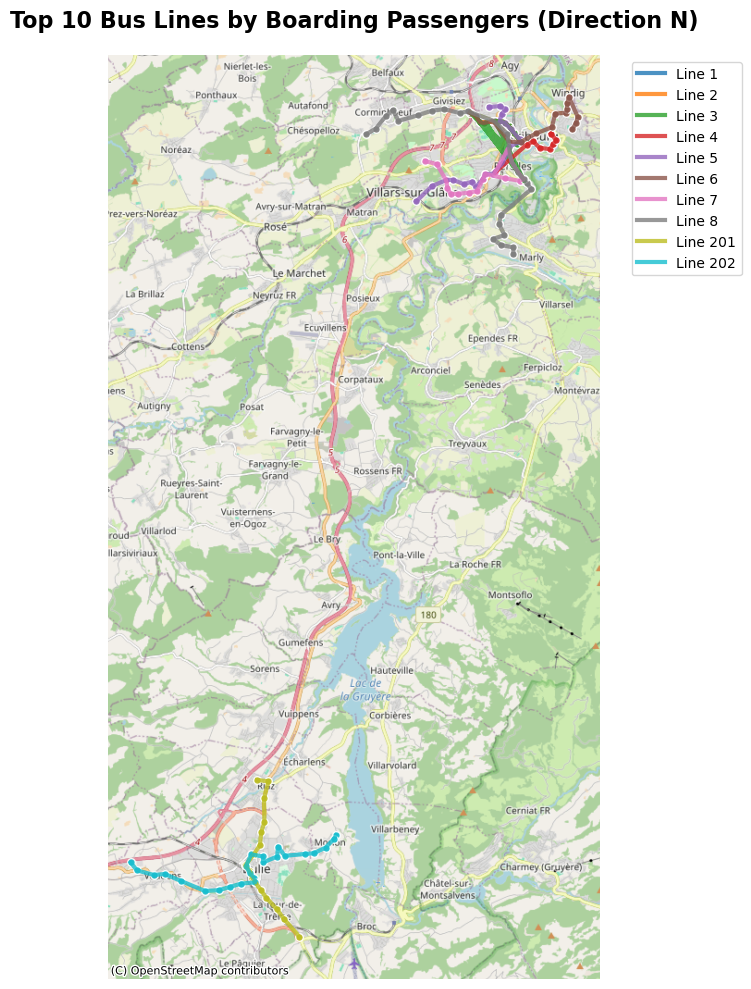

Top 10 lines by boarding passengers:
1. Line 1 - 295637 boarding passengers
2. Line 2 - 261792 boarding passengers
3. Line 3 - 80720 boarding passengers
4. Line 4 - 38412 boarding passengers
5. Line 5 - 225194 boarding passengers
6. Line 6 - 146115 boarding passengers
7. Line 7 - 69403 boarding passengers
8. Line 8 - 119318 boarding passengers
9. Line 201 - 59753 boarding passengers
10. Line 202 - 63081 boarding passengers


In [14]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors

# Create GeoDataFrame from line_drawing_df
geometry = [Point(xy) for xy in zip(line_drawing_df['Longitude'], line_drawing_df['Latitude'])]
gdf = gpd.GeoDataFrame(line_drawing_df, geometry=geometry, crs='EPSG:4326')

# Convert to Web Mercator for contextily
gdf = gdf.to_crs('EPSG:3857')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Generate distinct colors for each line
unique_lines = sorted(gdf['Line'].unique())
colors = plt.cm.tab10(range(len(unique_lines)))
line_colors = dict(zip(unique_lines, colors))

# Plot each line
for line_num in unique_lines:
    line_data = gdf[gdf['Line'] == line_num].sort_values('StopSeq')
    
    if len(line_data) > 1:  # Need at least 2 points to draw a line
        # Create LineString from the coordinates
        coords = [(row.geometry.x, row.geometry.y) for _, row in line_data.iterrows()]
        line_geom = LineString(coords)
        
        # Plot the line
        ax.plot(*line_geom.xy, color=line_colors[line_num], linewidth=3, 
                alpha=0.8, label=f'Line {int(line_num)}')
        
        # Plot the stops as small points
        line_data.plot(ax=ax, color=line_colors[line_num], markersize=30, 
                      alpha=0.9, edgecolor='white', linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

ax.set_title('Top 10 Bus Lines by Boarding Passengers (Direction N)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 10 lines by boarding passengers:")
for i, line in enumerate(unique_lines, 1):
    total_passengers = lines_data[line]
    print(f"{i}. Line {int(line)} - {total_passengers:.0f} boarding passengers")

In [ ]:
wuhu

In [39]:
plcs_with_on_off

,Day,Arrival,Departure,Punctuality,Distance,Latitude,Longitude,Data,Timetable,Block,JourneySeq,Line,Journey,StopSeq,Stop,StopName,Punctuality_Seconds,Didok,On_Second_Class,Off_Second_Class,Day_Type,Waiting_Time,Waiting_Time_Seconds,Direction,Hour,Passenger_Count
Vehicle,,,,,,,,,,,,,,,,,,,,,,,,,,
168,2024-01-25,2024-01-25 11:11:51,2024-01-25 11:11:57,0 days 00:00:57,1244.0,46.796830,7.146135,263,4.0,1025.0,7.0,336.0,33635.0,2.0,858885902.0,"Fribourg, bluefactory",57.0,8588859,1.23,0.06,lu-ve-scol,0 days 00:00:06,6.0,6,11,1.170000e+00
168,2024-01-25,2024-01-25 11:13:45,2024-01-25 11:13:45,0 days 00:01:45,562.0,46.792828,7.143368,263,4.0,1025.0,7.0,336.0,33635.0,3.0,850463301.0,"Fribourg, Rte de la Glâne",105.0,8504633,0.15,0.06,lu-ve-scol,0 days 00:00:00,0.0,6,11,1.260000e+00
168,2024-01-25,2024-01-25 11:14:23,2024-01-25 11:14:23,0 days 00:01:23,362.0,46.790860,7.140273,263,4.0,1025.0,7.0,336.0,33635.0,4.0,850463401.0,"Villars-sur-Glâne, Le Moléson",83.0,8504634,1.02,0.34,lu-ve-scol,0 days 00:00:00,0.0,6,11,1.940000e+00
168,2024-01-25,2024-01-25 11:14:56,2024-01-25 11:14:56,0 days 00:01:26,303.0,46.789941,7.136855,263,4.0,1025.0,7.0,336.0,33635.0,5.0,850428101.0,"Villars-sur-Glâne, Daillettes",86.0,8504281,0.71,0.72,lu-ve-scol,0 days 00:00:00,0.0,6,11,1.930000e+00
168,2024-01-25,2024-01-25 11:15:21,2024-01-25 11:15:21,0 days 00:01:21,350.0,46.788863,7.132995,263,4.0,1025.0,7.0,336.0,33635.0,6.0,850462301.0,"Villars-sur-Glâne, Planafaye",81.0,8504623,0.26,0.37,lu-ve-scol,0 days 00:00:00,0.0,6,11,1.820000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,2024-01-15,2024-01-15 23:18:41,2024-01-15 23:19:04,0 days 00:00:34,140.0,46.615696,7.057483,262,1.0,1508.0,43.0,201.0,20924.0,11.0,859328201.0,"Bulle, St-Denis",34.0,8593282,1.00,1.25,lu-ve-scol,0 days 00:00:23,23.0,2,23,1.236000e+01
855,2024-01-15,2024-01-15 23:19:52,2024-01-15 23:19:52,0 days 00:00:52,342.0,46.613355,7.059940,262,1.0,1508.0,43.0,201.0,20924.0,12.0,857773001.0,"Bulle, jardin Anglais",52.0,8577730,0.00,0.00,lu-ve-scol,0 days 00:00:00,0.0,2,23,1.236000e+01
855,2024-01-15,2024-01-15 23:20:18,2024-01-15 23:20:26,0 days 00:00:56,233.0,46.611631,7.061700,262,1.0,1508.0,43.0,201.0,20924.0,13.0,859328801.0,"La Tour-de-Trême, St-Michel",56.0,8593288,0.00,1.25,lu-ve-scol,0 days 00:00:08,8.0,2,23,3.640000e+00


,Line,Direction,StopName,Didok,Stop,Average_Delay_Seconds,P90_Delay_Seconds,P50_Delay_Seconds,P10_Delay_Seconds
0,1.0,1,"Fribourg, Place Georges Python",8577810,857781002.0,43.168539,95.8,38.0,-7.4
1,1.0,1,"Fribourg, Université",8577811,857781102.0,110.477273,183.9,102.0,41.0
2,1.0,1,"Fribourg, Ste-Thérèse",8577812,857781202.0,104.704545,170.1,93.5,47.0
3,1.0,1,"Fribourg, Vuille",8577820,857782002.0,85.738636,145.6,77.5,26.1
4,1.0,1,"Givisiez, Mont Carmel",8587238,858723802.0,19.939024,68.7,8.5,-17.8
...,...,...,...,...,...,...,...,...,...
3923,4931.0,1,"Semsales, gare",8504033,850403302.0,154.857143,167.7,159.5,137.1
3924,4931.0,1,"Vaulruz, village",8505233,850523302.0,139.714286,170.3,135.0,111.1
3925,4931.0,1,"Châtel-St-Denis, gare",8577718,857771813.0,-86.733333,8.0,-4.0,-349.8
3926,4931.0,1,"Bulle, gare routière",8577725,857772510.0,-114.071429,-70.1,-122.5,-156.2


In [ ]:
stops_metadata


,StopName,Didok,Platform,Short_Name,Latitude,Longitude,Average_Delay_Seconds,P90_Delay_Seconds,P50_Delay_Seconds,P10_Delay_Seconds,Line,Line_Avg_Delay_Seconds,Line_P90_Delay_Seconds,Line_P50_Delay_Seconds,Line_P10_Delay_Seconds
Stop,,,,,,,,,,,,,,,
850023801,"Bulle, Verdel",8500238,1,BULrtv,46.625099,7.066065,189.367052,341.0,161.0,69.0,202.0,190.501837,341.0,162.0,70.0
850023801,"Bulle, Verdel",8500238,1,BULrtv,46.625099,7.066065,189.367052,341.0,161.0,69.0,280.0,33.555556,143.6,43.0,-73.8
850023801,"Bulle, Verdel",8500238,1,BULrtv,46.625099,7.066065,189.367052,341.0,161.0,69.0,331.0,179.214286,326.0,150.0,69.1
850023802,"Bulle, Verdel",8500238,2,BULrtv,46.624744,7.065967,132.812908,199.2,120.0,74.8,202.0,132.812908,199.2,120.0,74.8
850072901,"Tramelan, garage CJ",8500729,1,DEPtra,47.246393,7.233253,1015.300000,1900.4,742.5,348.7,909.0,998.888889,1973.2,478.0,348.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999998801,"Bulle, La Léchère",9999988,1,SPElec,46.617665,7.045063,660.227273,952.4,573.5,371.6,901.0,660.227273,952.4,573.5,371.6
999998901,"Bulle, Rue des Baladins",9999989,1,RUEbal,46.610138,7.047311,-38.058824,77.7,-63.0,-150.2,901.0,-38.058824,77.7,-63.0,-150.2
999999201,"Châtel-St-Denis, Halle Triple",9999992,1,HALtri,46.536425,6.897592,26.892116,223.0,25.0,-168.0,481.0,133.600000,479.0,94.0,-175.2


# Important lines & stops

1. DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)

Summary by Bus Line:
        Total_Boarding  Unique_Vehicles  Unique_Journeys
Line                                                    
1.0          295636.73               41              279
2.0          261791.90               48              288
5.0          225194.13               28              260
6.0          146115.06               29              153
8.0          119317.81               66              151
...                ...              ...              ...
903.0          1729.09               23                6
13.0           1719.50               42               32
901.0          1686.12               21                4
259.0          1327.28                3               10
4931.0          653.86                2                1

[77 rows x 3 columns]

2A. HOURLY BOARDING PATTERNS BY LINE

Sample of hourly boarding demand (first few lines and hours):
           Hourly_Boarding
Line Hour                 
1.0  0      

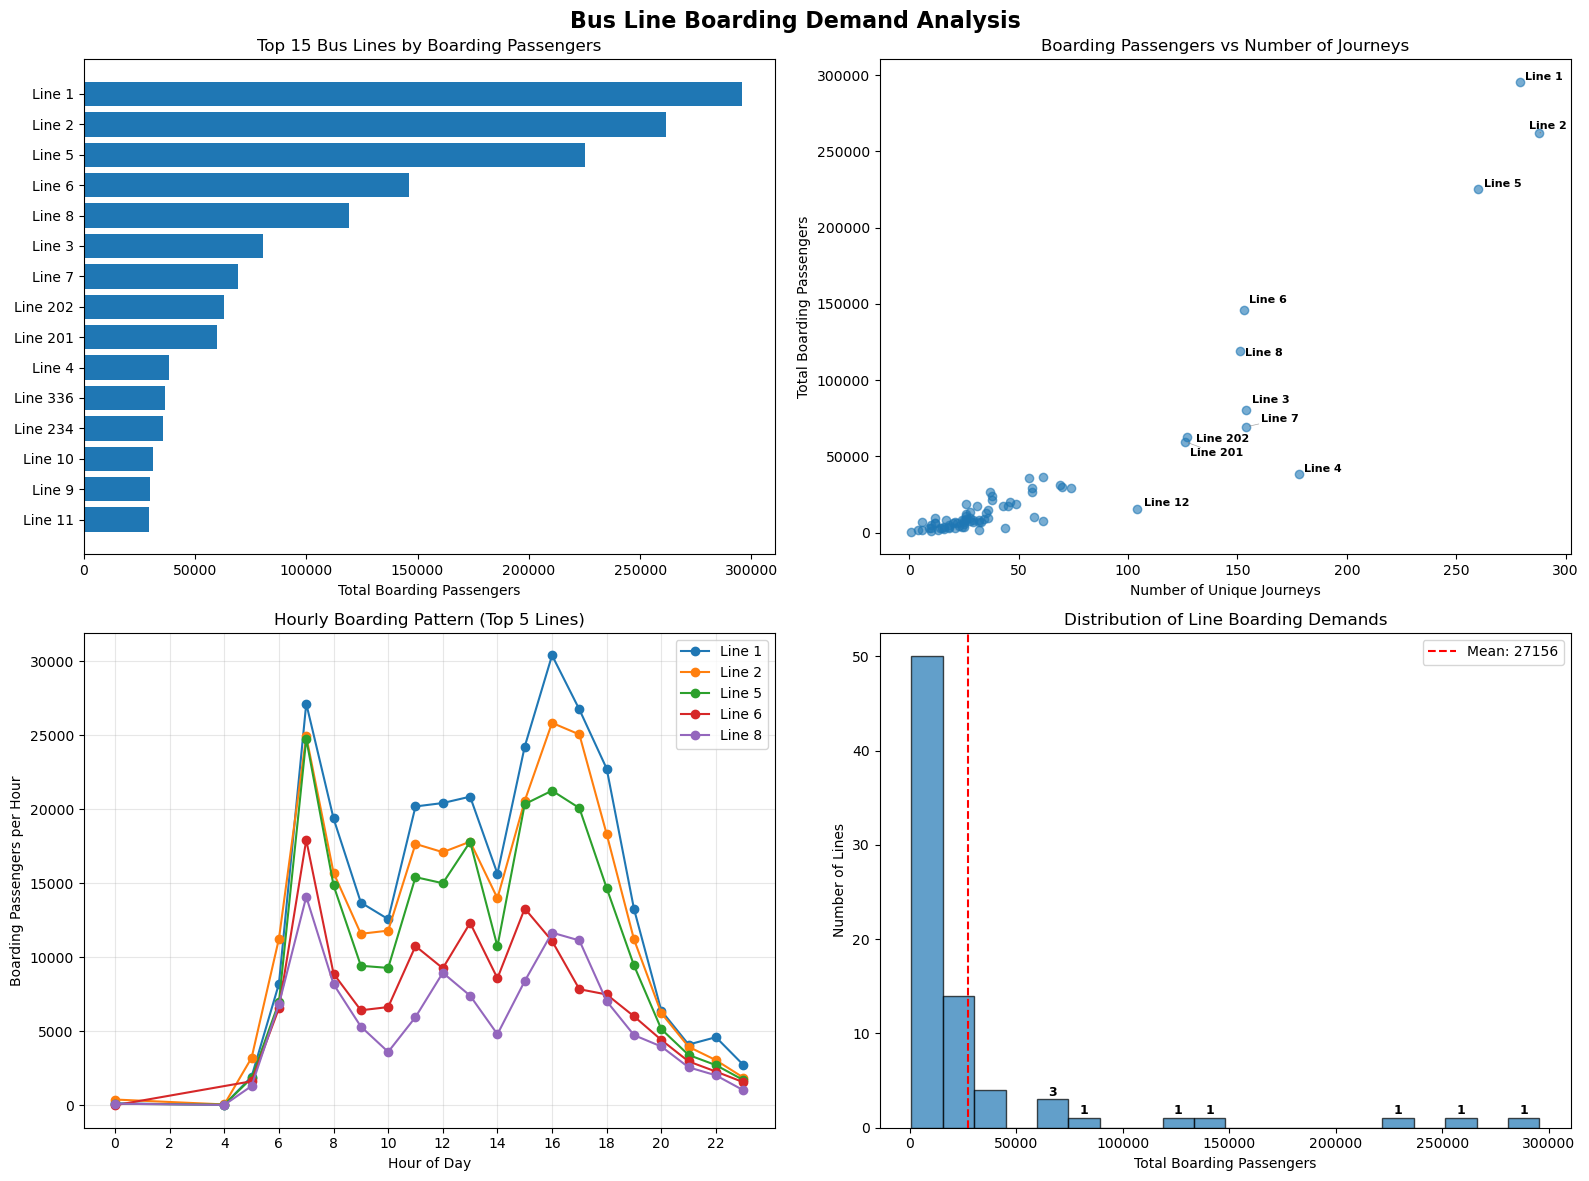

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Assuming your dataframe is called plcs_with_on_off
# df = plcs_with_on_off

def analyze_bus_line_demand(df):
    """
    Comprehensive analysis of bus line demand - Boarding passengers only
    """
    
    # Convert Arrival column to datetime if it's not already
    df['Arrival'] = pd.to_datetime(df['Arrival'])
    df['Hour'] = df['Arrival'].dt.hour
    
    # 1. Basic demand analysis per line (boarding only)
    print("=" * 60)
    print("1. DEMAND ANALYSIS BY BUS LINE (BOARDING ONLY)")
    print("=" * 60)
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    # Calculate total passengers getting on for each line
    line_demand = df_reset.groupby('Line').agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles
        'Journey': 'nunique'   # Number of unique journeys
    }).round(2)
    
    # Rename columns for clarity
    line_demand.columns = ['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys']
    
    print("\nSummary by Bus Line:")
    print(line_demand.sort_values('Total_Boarding', ascending=False))
    
    # 2a. Demand during the day (hourly analysis)
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY LINE")
    print("=" * 60)
    
    # Create hourly demand analysis
    hourly_demand = df_reset.groupby(['Line', 'Hour']).agg({
        'On_Second_Class': 'sum'
    }).round(2)
    
    hourly_demand.columns = ['Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of hourly boarding demand (first few lines and hours):")
    print(hourly_demand.head(20))
    
    # 2b. Total boarding summary
    print("\n" + "=" * 60)
    print("2B. TOTAL BOARDING BY LINE")
    print("=" * 60)
    
    boarding_summary = df_reset.groupby('Line').agg({
        'On_Second_Class': ['sum', 'mean', 'count']
    }).round(2)
    
    # Flatten column names
    boarding_summary.columns = ['Total_Boarding', 'Avg_Boarding_Per_Stop', 'Boarding_Records']
    
    print("\nBoarding Analysis:")
    print(boarding_summary.sort_values('Total_Boarding', ascending=False))
    
    # 3. Rank bus lines based on boarding demand
    print("\n" + "=" * 60)
    print("3. BUS LINE RANKING BY BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = line_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Total_Boarding'].rank(ascending=False)
    
    # Sort by total boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Total_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Line Rankings (Top 20):")
    print(ranking_df[['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys', 
                     'Overall_Rank']].head(20))
    
    return line_demand, hourly_demand_reset, ranking_df

def create_visualizations(df, line_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Line Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 lines by total boarding
    top_lines = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_lines)), top_lines['Total_Boarding'])
    axes[0, 0].set_yticks(range(len(top_lines)))
    axes[0, 0].set_yticklabels([f"Line {int(line)}" for line in top_lines.index])
    axes[0, 0].set_xlabel('Total Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Lines by Boarding Passengers')
    axes[0, 0].invert_yaxis()
    
    # 2. Boarding vs Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Unique_Journeys'], ranking_df['Total_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Number of Unique Journeys')
    axes[0, 1].set_ylabel('Total Boarding Passengers')
    axes[0, 1].set_title('Boarding Passengers vs Number of Journeys')
    
    # Add text labels for lines with more than 100 unique journeys
    from adjustText import adjust_text
    texts = []
    for line, row in ranking_df.iterrows():
        if row['Unique_Journeys'] > 100:
            text = axes[0, 1].text(row['Unique_Journeys'], row['Total_Boarding'], 
                                 f'Line {int(line)}', fontsize=8, fontweight='bold')
            texts.append(text)
    
    # Adjust text positions to avoid overlap
    if texts:
        adjust_text(texts, ax=axes[0, 1], 
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    
    # 3. Hourly boarding pattern for top 5 lines
    top_5_lines = ranking_df.head(5).index
    for line in top_5_lines:
        line_hourly = hourly_demand_reset[hourly_demand_reset['Line'] == line]
        if not line_hourly.empty:
            axes[1, 0].plot(line_hourly['Hour'], line_hourly['Hourly_Boarding'], 
                           marker='o', label=f'Line {int(line)}')
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Boarding Passengers per Hour')
    axes[1, 0].set_title('Hourly Boarding Pattern (Top 5 Lines)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of line boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Total_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Total Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Lines')
    axes[1, 1].set_title('Distribution of Line Boarding Demands')
    axes[1, 1].axvline(ranking_df['Total_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Total_Boarding"].mean():.0f}')
    
    # Add text above bars for bins with >50000 passengers
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > 50000 and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + 0.1  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_peak_hours_analysis(df):
    """
    Additional analysis for peak hours (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    
    # Overall peak hours
    hourly_total = df_reset.groupby('Hour')['On_Second_Class'].sum()
    peak_hours = hourly_total.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS (BOARDING ONLY)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.0f} total boardings")
    
    # Peak hours by line (for top 10 lines)
    top_10_lines = df_reset.groupby('Line')['On_Second_Class'].sum().nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest lines:")
    for line in top_10_lines:
        line_data = df_reset[df_reset['Line'] == line]
        line_hourly = line_data.groupby('Hour')['On_Second_Class'].sum()
        if not line_hourly.empty:
            peak_hour = line_hourly.idxmax()
            peak_demand = line_hourly.max()
            print(f"Line {int(line)}: Peak at {peak_hour:02d}:00 with {peak_demand:.0f} boardings")

# Example usage:
# Uncomment and run the following lines with your dataframe

# line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)
# create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)
# generate_peak_hours_analysis(plcs_with_on_off)

# Additional quick summary function
def quick_summary(df):
    """
    Quick summary statistics (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    print("QUICK SUMMARY (BOARDING ONLY)")
    print("=" * 40)
    print(f"Total unique bus lines: {df_reset['Line'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total passenger boardings: {df_reset['On_Second_Class'].sum():,.0f}")
    print(f"Average boardings per stop: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Day'].min()} to {df_reset['Day'].max()}")
    
# Run the main analysis
line_demand, hourly_demand, ranking = analyze_bus_line_demand(plcs_with_on_off)

# Create visualizations
create_visualizations(plcs_with_on_off, line_demand, hourly_demand, ranking)

# # Generate peak hours analysis
# generate_peak_hours_analysis(plcs_with_on_off)

# # Get quick summary
# quick_summary(plcs_with_on_off)

1. DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)

Summary by Bus Stop (Top 20):
                                  Total_Boarding  Unique_Vehicles  \
StopName                                                            
Fribourg/Freiburg, Pl. Gare            350876.46              115   
Fribourg, St-Pierre                     86008.10               55   
Fribourg/Freiburg, gare routière        69385.57              179   
Fribourg, Charmettes                    67089.04              183   
Fribourg, Tilleul/Cathédrale            60613.69              180   
Fribourg, Industrie                     45092.87              110   
Marly, Grand Pré                        35155.04              170   
Bulle, Château-d'en-Bas                 27376.98              137   
Fribourg, Boschung                      24738.65              161   
Bulle, Place de la Gare                 24530.83               20   
Romont FR, gare                         22720.21              114   
Fribourg, Place Georges P

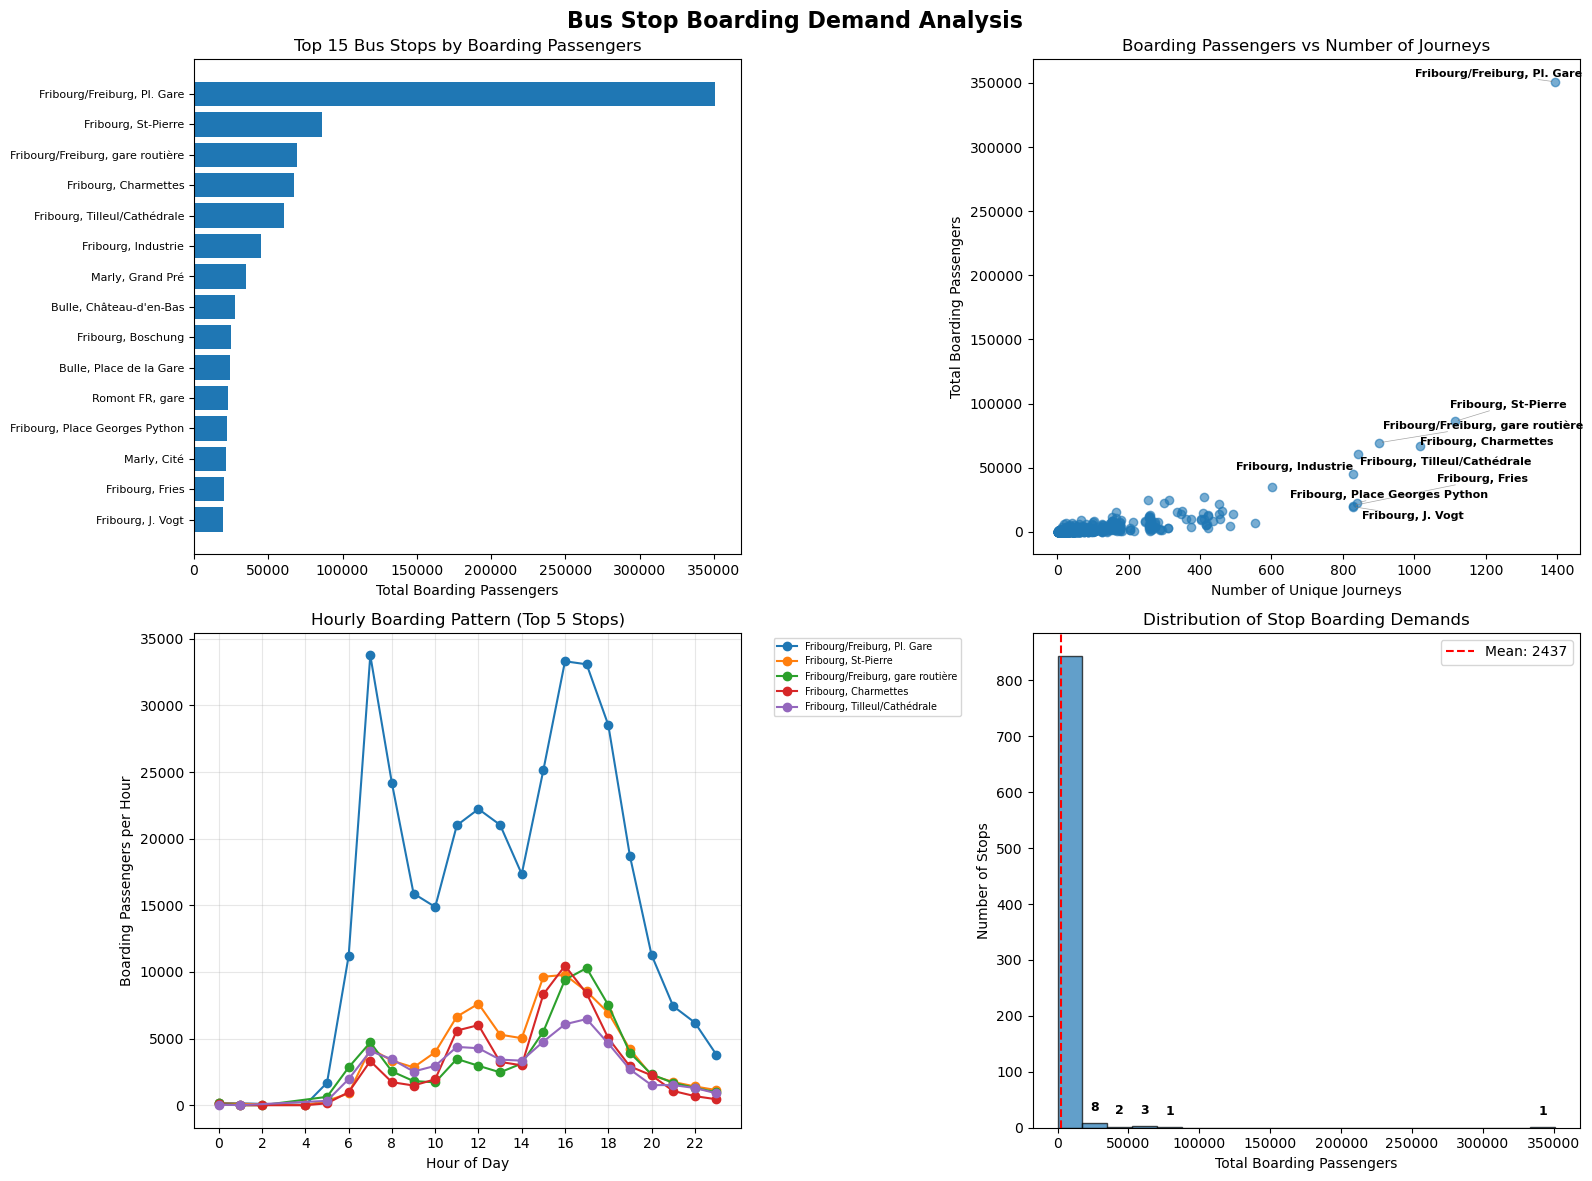

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def analyze_bus_stop_demand(df):
    """
    Comprehensive analysis of bus stop demand - Boarding passengers only
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    # Convert Arrival column to datetime if it's not already
    df_reset['Arrival'] = pd.to_datetime(df_reset['Arrival'])
    df_reset['Hour'] = df_reset['Arrival'].dt.hour
    
    # 1. Basic demand analysis per stop
    print("=" * 60)
    print("1. DEMAND ANALYSIS BY BUS STOP (BOARDING ONLY)")
    print("=" * 60)
    
    # Calculate total passengers getting on for each stop
    stop_demand = df_reset.groupby('StopName').agg({
        'On_Second_Class': 'sum',
        'Vehicle': 'nunique',  # Number of unique vehicles
        'Journey': 'nunique'   # Number of unique journeys
    }).round(2)
    
    # Rename columns for clarity
    stop_demand.columns = ['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys']
    
    print("\nSummary by Bus Stop (Top 20):")
    print(stop_demand.sort_values('Total_Boarding', ascending=False).head(20))
    
    # 2a. Demand during the day (hourly analysis)
    print("\n" + "=" * 60)
    print("2A. HOURLY BOARDING PATTERNS BY STOP")
    print("=" * 60)
    
    # Create hourly demand analysis
    hourly_demand = df_reset.groupby(['StopName', 'Hour']).agg({
        'On_Second_Class': 'sum'
    }).round(2)
    
    hourly_demand.columns = ['Hourly_Boarding']
    
    # Reset index for easier plotting
    hourly_demand_reset = hourly_demand.reset_index()
    
    print("\nSample of hourly boarding demand (first few stops and hours):")
    print(hourly_demand.head(20))
    
    # 3. Rank bus stops based on boarding demand
    print("\n" + "=" * 60)
    print("3. BUS STOP RANKING BY BOARDING DEMAND")
    print("=" * 60)
    
    # Create comprehensive ranking
    ranking_df = stop_demand.copy()
    ranking_df['Demand_Rank'] = ranking_df['Total_Boarding'].rank(ascending=False)
    
    # Sort by total boarding (primary ranking metric)
    ranking_df = ranking_df.sort_values('Total_Boarding', ascending=False)
    ranking_df['Overall_Rank'] = range(1, len(ranking_df) + 1)
    
    print("\nBus Stop Rankings (Top 20):")
    print(ranking_df[['Total_Boarding', 'Unique_Vehicles', 'Unique_Journeys', 
                     'Overall_Rank']].head(20))
    
    return stop_demand, hourly_demand_reset, ranking_df

def create_stop_visualizations(df, stop_demand, hourly_demand_reset, ranking_df):
    """
    Create visualizations for the stop boarding demand analysis
    """
    
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Bus Stop Boarding Demand Analysis', fontsize=16, fontweight='bold')
    
    # 1. Top 15 stops by total boarding
    top_stops = ranking_df.head(15)
    axes[0, 0].barh(range(len(top_stops)), top_stops['Total_Boarding'])
    axes[0, 0].set_yticks(range(len(top_stops)))
    # Show full stop names
    axes[0, 0].set_yticklabels(top_stops.index, fontsize=8)
    axes[0, 0].set_xlabel('Total Boarding Passengers')
    axes[0, 0].set_title('Top 15 Bus Stops by Boarding Passengers')
    axes[0, 0].invert_yaxis()
    
    # 2. Boarding vs Journeys scatter plot
    axes[0, 1].scatter(ranking_df['Unique_Journeys'], ranking_df['Total_Boarding'], alpha=0.6)
    axes[0, 1].set_xlabel('Number of Unique Journeys')
    axes[0, 1].set_ylabel('Total Boarding Passengers')
    axes[0, 1].set_title('Boarding Passengers vs Number of Journeys')
    
    # Add text labels for stops with more than 800 unique journeys
    from adjustText import adjust_text
    texts = []
    for stop, row in ranking_df.iterrows():
        if row['Unique_Journeys'] > 800:
            # Show full stop name
            text = axes[0, 1].text(row['Unique_Journeys'], row['Total_Boarding'], 
                                 stop, fontsize=8, fontweight='bold')
            texts.append(text)
    
    # Adjust text positions to avoid overlap
    if texts:
        adjust_text(texts, ax=axes[0, 1], 
                   arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7, lw=0.5))
    
    # 3. Hourly boarding pattern for top 5 stops
    top_5_stops = ranking_df.head(5).index
    for stop in top_5_stops:
        stop_hourly = hourly_demand_reset[hourly_demand_reset['StopName'] == stop]
        if not stop_hourly.empty:
            # Show full stop name in legend
            axes[1, 0].plot(stop_hourly['Hour'], stop_hourly['Hourly_Boarding'], 
                           marker='o', label=stop)
    
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Boarding Passengers per Hour')
    axes[1, 0].set_title('Hourly Boarding Pattern (Top 5 Stops)')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 4. Distribution of stop boarding demands
    n, bins, patches = axes[1, 1].hist(ranking_df['Total_Boarding'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Total Boarding Passengers')
    axes[1, 1].set_ylabel('Number of Stops')
    axes[1, 1].set_title('Distribution of Stop Boarding Demands')
    axes[1, 1].axvline(ranking_df['Total_Boarding'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {ranking_df["Total_Boarding"].mean():.0f}')
    
    # Add text above bars for bins with >5000 passengers (adjusted threshold for stops)
    for i, (count, left_edge, right_edge) in enumerate(zip(n, bins[:-1], bins[1:])):
        if left_edge > 5000 and count > 0:
            # Position text at the center of the bin, above the bar
            x_pos = (left_edge + right_edge) / 2
            y_pos = count + max(n) * 0.02  # Slightly above the bar
            axes[1, 1].text(x_pos, y_pos, f'{int(count)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def generate_stop_peak_hours_analysis(df):
    """
    Additional analysis for peak hours at stops (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    df_reset['Hour'] = pd.to_datetime(df_reset['Arrival']).dt.hour
    
    # Overall peak hours
    hourly_total = df_reset.groupby('Hour')['On_Second_Class'].sum()
    peak_hours = hourly_total.nlargest(3)
    
    print("\n" + "=" * 60)
    print("PEAK HOURS ANALYSIS FOR STOPS (BOARDING ONLY)")
    print("=" * 60)
    print(f"\nTop 3 Peak Hours (system-wide):")
    for hour, demand in peak_hours.items():
        print(f"Hour {hour:02d}:00 - {demand:.0f} total boardings")
    
    # Peak hours by stop (for top 10 stops)
    top_10_stops = df_reset.groupby('StopName')['On_Second_Class'].sum().nlargest(10).index
    
    print(f"\nPeak hour for each of the top 10 busiest stops:")
    for stop in top_10_stops:
        stop_data = df_reset[df_reset['StopName'] == stop]
        stop_hourly = stop_data.groupby('Hour')['On_Second_Class'].sum()
        if not stop_hourly.empty:
            peak_hour = stop_hourly.idxmax()
            peak_demand = stop_hourly.max()
            stop_display = stop[:30] + '...' if len(stop) > 30 else stop
            print(f"{stop_display}: Peak at {peak_hour:02d}:00 with {peak_demand:.0f} boardings")

def quick_stop_summary(df):
    """
    Quick summary statistics for stops (boarding only)
    """
    # Reset index to make Vehicle a column if it's currently the index
    if df.index.name == 'Vehicle':
        df_reset = df.reset_index()
    else:
        df_reset = df.copy()
    
    print("QUICK SUMMARY FOR STOPS (BOARDING ONLY)")
    print("=" * 40)
    print(f"Total unique bus stops: {df_reset['StopName'].nunique()}")
    print(f"Total unique vehicles: {df_reset['Vehicle'].nunique()}")
    print(f"Total passenger boardings: {df_reset['On_Second_Class'].sum():,.0f}")
    print(f"Average boardings per record: {df_reset['On_Second_Class'].mean():.2f}")
    print(f"Date range: {df_reset['Day'].min()} to {df_reset['Day'].max()}")

# Run the main analysis
stop_demand, hourly_demand, ranking = analyze_bus_stop_demand(plcs_with_on_off)

# Create visualizations
create_stop_visualizations(plcs_with_on_off, stop_demand, hourly_demand, ranking)

# # Generate peak hours analysis
# generate_stop_peak_hours_analysis(plcs_with_on_off)

# # Get quick summary
# quick_stop_summary(plcs_with_on_off)

# Delay Analysis

## Stop Delay

### Delay Sum

In [52]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stations and lines by total delay impact
    Impact = sum of (delay × passenger_count) - shows total passenger-time lost
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Calculate delay impact (delay * passengers)
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Total delay impact = sum of (delay * passengers)
        delay_impact = (delays * passengers).sum()
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Delay_Impact': delay_impact,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay impact stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Delay_Impact')
    
    print(f"\nTop {n_stops} stations by delay impact (delay × passengers):")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Delay_Impact']:.0f} passenger-seconds")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            delay_impact = (delays * passengers).sum()
            
            line_results.append({
                'Line': line_id,
                'Delay_Impact': delay_impact
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Delay_Impact')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Delay_Impact']:.0f} passenger-seconds")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by delay impact (delay × passengers):
8592374: Fribourg/Freiburg, Pl. Gare - 88214764 passenger-seconds
8589161: Fribourg, St-Pierre - 73867277 passenger-seconds
8588858: Fribourg, J. Vogt - 72812709 passenger-seconds
8587255: Fribourg, Tilleul/Cathédrale - 72615233 passenger-seconds
8589155: Fribourg, Fries - 69341174 passenger-seconds
8587356: Fribourg, Pont-Zaehringen - 66089324 passenger-seconds
8589154: Fribourg, Industrie - 60912824 passenger-seconds
8577810: Fribourg, Place Georges Python - 60777420 passenger-seconds
8589162: Fribourg, Stadtberg - 60167742 passenger-seconds
8577784: Fribourg, Beauregard - 55061001 passenger-seconds

Top 5 lines at each station:

Fribourg/Freiburg, Pl. Gare:
  Line 2: 25645838 passenger-seconds
  Line 1: 20567037 passenger-seconds
  Line 6: 15050914 passenger-seconds
  Line 8: 9733208 passenger-seconds
  Line 5: 6024873 passenger-seconds

Fribourg, St-Pierre:
  Line 2: 26466653 pa

### Delay Average

In [53]:
import pandas as pd
import numpy as np

def analyze_top_delays_weighted(df, n_stops=5, m_lines=3, min_occurrences=100):
    """
    Find top delay stops and lines weighted by passenger count
    Aggregates by Didok (station) instead of individual Stop IDs
    """
    
    # Reset index if needed
    if df.index.name == 'Vehicle':
        df = df.reset_index()
    
    # Filter stops with enough data (by Didok)
    didok_counts = df['Didok'].value_counts()
    frequent_didoks = didok_counts[didok_counts > min_occurrences].index
    df_filtered = df[df['Didok'].isin(frequent_didoks)]
    
    print(f"Analyzing {len(frequent_didoks)} stations (Didok) with > {min_occurrences} records")
    
    # Calculate weighted median for each Didok station
    didok_results = []
    for didok_id in frequent_didoks:
        didok_data = df_filtered[df_filtered['Didok'] == didok_id]
        
        # Weight delays by passenger count
        delays = didok_data['Punctuality_Seconds']
        passengers = didok_data['Passenger_Count']
        
        # Weight delays by passenger count - sum of (delay * passengers)
        weighted_delay_sum = (delays * passengers).sum()
        total_passengers = passengers.sum()
        weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
        
        didok_results.append({
            'Didok': didok_id,
            'StationName': didok_data['StopName'].iloc[0],  # Use first stop name as station name
            'Weighted_Delay': weighted_delay,
            'Total_Passengers': passengers.sum()
        })
    
    # Get top delay stations
    didok_df = pd.DataFrame(didok_results)
    top_stations = didok_df.nlargest(n_stops, 'Weighted_Delay')
    
    print(f"\nTop {n_stops} stations by passenger-weighted delay:")
    for _, row in top_stations.iterrows():
        print(f"{int(row['Didok'])}: {row['StationName']} - {row['Weighted_Delay']:.1f}s")
    
    # For each top station, find worst lines
    print(f"\nTop {m_lines} lines at each station:")
    for _, station_row in top_stations.iterrows():
        station_data = df[df['Didok'] == station_row['Didok']]
        
        line_results = []
        for line_id in station_data['Line'].unique():
            line_data = station_data[station_data['Line'] == line_id]
            delays = line_data['Punctuality_Seconds']
            passengers = line_data['Passenger_Count']
            weighted_delay_sum = (delays * passengers).sum()
            total_passengers = passengers.sum()
            weighted_delay = weighted_delay_sum / total_passengers if total_passengers > 0 else 0
            
            line_results.append({
                'Line': line_id,
                'Weighted_Delay': weighted_delay
            })
        
        line_df = pd.DataFrame(line_results)
        top_lines = line_df.nlargest(m_lines, 'Weighted_Delay')
        
        print(f"\n{station_row['StationName']}:")
        for _, line_row in top_lines.iterrows():
            print(f"  Line {int(line_row['Line'])}: {line_row['Weighted_Delay']:.1f}s")

# Usage:
analyze_top_delays_weighted(plcs_with_on_off, n_stops=10, m_lines=5, min_occurrences=100)

Analyzing 799 stations (Didok) with > 100 records

Top 10 stations by passenger-weighted delay:
8577764: Boltigen, Bahnhof - 1029.4s
8577830: St-Aubin FR, Le-Haut - 449.9s
8577831: Delley, En Roche - 444.6s
8504887: St-Aubin FR, église - 420.9s
8577832: Delley, école - 393.4s
8577829: St-Aubin FR, bif. - 364.6s
8507595: Belfaux, Arsenal - 346.3s
8591767: Fribourg, Route-de-Tavel - 345.1s
8504633: Fribourg, Rte de la Glâne - 322.1s
8510187: Portalban, école - 320.9s

Top 5 lines at each station:

Boltigen, Bahnhof:
  Line 259: 1029.4s

St-Aubin FR, Le-Haut:
  Line 544: 449.9s

Delley, En Roche:
  Line 544: 444.6s

St-Aubin FR, église:
  Line 544: 420.9s

Delley, école:
  Line 544: 393.4s

St-Aubin FR, bif.:
  Line 544: 434.6s
  Line 556: 143.5s

Belfaux, Arsenal:
  Line 545: 437.0s
  Line 544: 248.9s

Fribourg, Route-de-Tavel:
  Line 6: 348.3s
  Line 182: 344.1s
  Line 123: 322.0s
  Line 181: 258.5s

Fribourg, Rte de la Glâne:
  Line 470: 334.9s
  Line 336: 317.7s
  Line 337: 298.4s

Po

## Line Delay

In [ ]:
# Prepare base: filter plcs_with_on_off for valid delay values
valid_plcs = plcs_with_on_off[~plcs_with_on_off['Punctuality_Seconds'].isna() & ~plcs_with_on_off['Didok'].isna()]

# Aggregate delay stats by (Line, Direction, Didok)
delay_stats = (
    valid_plcs.groupby(['Line', 'Direction', 'Didok'])
    .agg(
        Average_Delay_Seconds=('Punctuality_Seconds', 'mean'),
        P90_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.9)),
        P50_Delay_Seconds=('Punctuality_Seconds', 'median'),
        P10_Delay_Seconds=('Punctuality_Seconds', lambda x: x.quantile(0.1))
    )
    .reset_index()
)

# Merge stop name and Stop ID
delay_stats = delay_stats.merge(
    stops_metadata[['Didok', 'StopName', 'Stop']],
    how='left',
    on='Didok'
)

# Final tidy order of columns
delay_stats = delay_stats[[
    'Line', 'Direction', 'StopName', 'Didok', 'Stop',
    'Average_Delay_Seconds', 'P90_Delay_Seconds', 'P50_Delay_Seconds', 'P10_Delay_Seconds'
]]

# Sort by Line, Direction, and Didok
delay_stats = delay_stats.sort_values(['Line', 'Direction', 'Didok'])

# Output result
stop_line_direction_delay_df = delay_stats

In [ ]:
import matplotlib.pyplot as plt

def plot_delay_profile_for_line(df, line_sequences, line, sequence_id=None):
    """
    Plot delay profile (P90, P50, P10) along the stops of a given line sequence.
    
    Parameters:
    df: DataFrame like stop_line_direction_delay_df
    line_sequences: Your line_sequences dictionary from sequence analysis
    line: Line number to visualize
    sequence_id: Optional. If specified, filters on this sequence/direction only
    
    Returns:
    Matplotlib plot showing delay profiles per stop
    """
    df_filtered = df[df['Line'] == line].copy()
    
    if sequence_id is not None:
        df_filtered = df_filtered[df_filtered['Direction'] == sequence_id]
    
    if df_filtered.empty:
        print("❌ No data found for the given line (and sequence if specified).")
        return
    
    # Get the correct order from sequence
    if sequence_id is not None and line in line_sequences and sequence_id in line_sequences[line]:
        # Get the sequence order using Didok IDs
        didok_sequence = line_sequences[line][sequence_id]
        
        # Create a mapping of Didok to position
        didok_to_position = {str(didok): i for i, didok in enumerate(didok_sequence)}
        
        # Add position column and sort by it
        df_filtered['Position'] = df_filtered['Didok'].astype(str).map(didok_to_position)
        df_filtered = df_filtered.dropna(subset=['Position']).sort_values('Position')
    else:
        # If no sequence specified, just sort by Didok (fallback)
        df_filtered = df_filtered.sort_values('Didok')
    
    if df_filtered.empty:
        print("❌ No matching stops found in the sequence data.")
        return
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered['StopName'], df_filtered['P90_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P90 Delay (Worst 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['P50_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P50 Delay (Median)')
    plt.plot(df_filtered['StopName'], df_filtered['P10_Delay_Seconds'], 
             marker='o', linewidth=2, markersize=6, label='P10 Delay (Best 10%)')
    plt.plot(df_filtered['StopName'], df_filtered['Average_Delay_Seconds'],
             marker='o', linewidth=2, markersize=6, label='Average_Delay_Seconds')
    
    # Add zero line for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='On Time')
    
    plt.title(f"Delay Profile for Line {line}" + 
              (f" - Sequence {sequence_id}" if sequence_id is not None else " (All Sequences)"))
    plt.xlabel("Stops (in route order)")
    plt.ylabel("Delay (seconds)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 Summary for Line {line}" + (f" Sequence {sequence_id}" if sequence_id else ""))
    print(f"  - Stops plotted: {len(df_filtered)}")
    print(f"  - Average P50 delay: {df_filtered['P50_Delay_Seconds'].mean():.1f} seconds")
    print(f"  - Worst stop (P90): {df_filtered.loc[df_filtered['P90_Delay_Seconds'].idxmax(), 'StopName']} ({df_filtered['P90_Delay_Seconds'].max():.1f}s)")

# Usage examples:
# Show all sequences for a line
# plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259)

# Show specific sequence
plot_delay_profile_for_line(stop_line_direction_delay_df, line_sequences, line=259, sequence_id=2)
# Ulmiz FR, Abzw. Lurtigen
# Châtel-St-Denis, Les Moilles 492
# Tafers, Oberdorf 123 182 917 181
# Ulmiz FR, Abzw. Lurtigen